In [1]:
import os
# 0 = all, 1 = INFO, 2 = WARNING, 3 = ERROR
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
import tensorflow_io as tfio
from matplotlib import pyplot as plt
import matplotlib
import numpy as np
#import audiomentations -- using tf for augmentations now
import keras
from keras import layers
import random
import glob
import math
import csv
import time
from datetime import datetime

In [2]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
    precision_recall_curve,
    log_loss,
    auc,
    average_precision_score
)
from scipy.interpolate import interp1d

In [3]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Flatten, BatchNormalization, Activation, MaxPooling2D, Dropout, GlobalAveragePooling2D, Reshape, Dense, Multiply, Concatenate, LSTM, Permute, RepeatVector, Softmax, Lambda

In [4]:
print(tf.__version__)

2.8.0


In [5]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [6]:
import psutil

mem = psutil.virtual_memory()
print(f"Total RAM:     {mem.total / 1e9:.2f} GB")
print(f"Available RAM: {mem.available / 1e9:.2f} GB")
print(f"Used RAM:      {mem.used / 1e9:.2f} GB")
print(f"RAM Usage:     {mem.percent}%")

Total RAM:     34.29 GB
Available RAM: 13.52 GB
Used RAM:      20.77 GB
RAM Usage:     60.6%


## Set Paths

In [7]:
print(os.getcwd())
os.chdir('C:\\Users\\foxir\\OneDrive\\Desktop\\Smart Rock\\gunshot-detection\\model\\working directory\\new notebooks')
print(os.getcwd())

c:\Users\foxir\OneDrive\Desktop\Smart Rock\gunshot-detection\model\working directory\new notebooks\seeded experiments\rainforest-gunshot
C:\Users\foxir\OneDrive\Desktop\Smart Rock\gunshot-detection\model\working directory\new notebooks


In [8]:
val_NEG = os.path.join('belize-data', 'Validation data', 'Background')
val_POS = os.path.join('belize-data', 'Validation data', 'Gunshot')
train_NEG = os.path.join('belize-data', 'Training data', 'Background')
train_POS = os.path.join('belize-data', 'Training data', 'Gunshot')

val_neg = [[(val_NEG+'\\'+item), 0] for item in os.listdir(val_NEG)]
del(val_neg[8]) # Contains clipped gunshot
val_pos = [[(val_POS+'\\'+item), 1] for item in os.listdir(val_POS)]
train_neg = [[(train_NEG+'\\'+item), 0] for item in os.listdir(train_NEG)]
train_pos = [[(train_POS+'\\'+item), 1] for item in os.listdir(train_POS)]

full_train = train_pos+train_neg
full_val = val_pos+val_neg

random.seed(42) # max distance between positives is 222, allowing a batch size of 256 to always include a positive when not upsampling
random.shuffle(full_train)
random.shuffle(full_val)

t_filepaths = [x[0] for x in full_train]
t_labels = [x[1] for x in full_train]

v_filepaths = [x[0] for x in full_val]
v_labels = [x[1] for x in full_val]

In [9]:
# Convert python list to tf.constant for gpu-accel augmentation during training
bg_files = [item[0] for item in train_neg]
bg_files = tf.constant(bg_files, dtype=tf.string)

In [10]:
# Get indices
indices = [i for i, value in enumerate(t_labels) if value == 1]

# Compute distances between consecutive indices
distances = [indices[i+1] - indices[i] for i in range(len(indices)-1)]

#print("Indices of 1s:", indices)
#print("Distances between 1s:", distances)
print("Mean distance between 1s:", np.mean(distances))
print("Max distance between 1s:", np.max(distances))
print("Stdev between 1s:", np.std(distances))

Mean distance between 1s: 48.08221476510067
Max distance between 1s: 390
Stdev between 1s: 48.7684394910974


In [11]:
# Get indices
indices = [i for i, value in enumerate(v_labels) if value == 1]

# Compute distances between consecutive indices
distances = [indices[i+1] - indices[i] for i in range(len(indices)-1)]

#print("Indices of 1s:", indices)
#print("Distances between 1s:", distances)
print("Mean distance between 1s:", np.mean(distances))
print("Max distance between 1s:", np.max(distances))
print("Stdev between 1s:", np.std(distances))

Mean distance between 1s: 47.38255033557047
Max distance between 1s: 483
Stdev between 1s: 53.64068841745484


In [ ]:
small_test_NEG = os.path.join('vietnam-data', 'imagesvietnamunbalanced_clips', 'test', 'noise')
small_test_POS = os.path.join('vietnam-data', 'imagesvietnamunbalanced_clips', 'test', 'gunshot')

small_test_pos = [[small_test_POS+'\\'+item, 1] for item in os.listdir(small_test_POS)]
small_test_neg = [[small_test_NEG+'\\'+item, 0] for item in os.listdir(small_test_NEG)]

full_small_test = small_test_pos + small_test_neg

random.seed(42)
random.shuffle(full_small_test)

small_test_filepaths = [x[0] for x in full_small_test]
small_test_labels = [x[1] for x in full_small_test]

## Initialize Functions

In [ ]:
# SAIL functions

import numpy as np

def combine_preds_vec(preds, eps=1e-12):
    """
    Compute the SAIL inner (non-sigmoided) combination for n predictions.
    Matches the mathematical definition:
    
      inner(p1,...,pn) = 1 -   sum_{1<=i<j<=n} (1-p_i)(1-p_j)
                           -------------------------------
                               sum_{k=1}^n p_k

    - preds may be a 1D array of length N (treated as a single example)
      or a 2D array of shape (B, N) for a batch of B examples.
    - Returns a scalar (if 1D input) or an array of shape (B,).
    - If sum_k p_k is numerically zero (<= eps) the function returns 0.0
      for that row (consistent with a safe numerical convention).
    """
    p = np.asarray(preds, dtype=np.float64)

    # normalize input shape to (B, N)
    squeezed = False
    if p.ndim == 0:
        raise ValueError("preds must be an array of length >= 1")
    if p.ndim == 1:
        p = p[np.newaxis, :]
        squeezed = True
    elif p.ndim > 2:
        raise ValueError("preds must be 1D or 2D (batch, features)")

    B, N = p.shape
    if N == 0:
        raise ValueError("No predictions provided (N == 0).")

    # N == 1: no pairwise terms, inner == p_1
    if N == 1:
        out = p[:, 0].astype(np.float64)
        return out[0] if squeezed else out

    # q_i = 1 - p_i
    q = 1.0 - p                     # shape (B, N)
    sum_q = np.sum(q, axis=1)       # shape (B,)
    sum_q2 = np.sum(q * q, axis=1)  # shape (B,)

    # sum_{i<j} q_i q_j = (sum_q^2 - sum_q2) / 2
    numer = (sum_q * sum_q - sum_q2) / 2.0   # shape (B,)

    denom = np.sum(p, axis=1)       # shape (B,)

    # safe division: if denom is near zero, set inner to 0.0
    safe = denom > eps
    inner = np.zeros_like(denom, dtype=np.float64)
    inner[safe] = 1.0 - (numer[safe] / (denom[safe] + eps))

    return inner[0] if squeezed else inner

def sigmoid_pred_vec(pf):
    """
    Numerically stable sigmoid-like mapping used in original code:
      x = 10*(pf - 0.5) and then logistic(x) with clipping to avoid overflow.
    Accepts scalar, 1D, or ND arrays and returns same shape.
    """
    pf = np.asarray(pf, dtype=np.float64)
    x = 10.0 * (pf - 0.5)
    # clip to avoid extreme exponentials
    x = np.clip(x, -10.0, 10.0)

    # stable computation
    out = np.empty_like(x)
    pos = x >= 0
    if np.any(pos):
        out[pos] = 1.0 / (1.0 + np.exp(-x[pos]))
    if np.any(~pos):
        ex = np.exp(x[~pos])
        out[~pos] = ex / (1.0 + ex)
    return out

def sail_preds_vec(preds, start=1):
    """
    Generalized SAIL prediction combiner.
    preds: array-like shape (B, N) or (N,)
    start: integer column index to start using predictions from (default 1
           to preserve previous behaviour that ignored column 0).
           Set start=0 to use all columns.
    Returns: sigmoid(combined) of shape (B,) or scalar if input was 1D.
    """
    arr = np.asarray(preds, dtype=np.float64)
    if arr.ndim == 1:
        p = arr[start:]
    else:
        if start < 0 or start > arr.shape[1]:
            raise IndexError("start index out of range for preds columns.")
        p = arr[:, start:]

    combined = combine_preds_vec(p)
    return sigmoid_pred_vec(combined)

In [13]:
desired_sr = 8000

@tf.function
def load_wav_8k_mono_tf(filename, label):
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # resample wav if sample rate is not as desired
    wav = tf.cond(tf.not_equal(sample_rate, desired_sr),
                  lambda: tfio.audio.resample(wav, rate_in=sample_rate, rate_out=desired_sr),
                  lambda: wav)
    wav = tf.squeeze(wav, axis=-1)
    label = tf.cast(label, dtype=tf.float32)
    return wav, label

@tf.function
def load_wav_8k_mono_tf_nolabel(filename):
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # resample wav if sample rate is not as desired
    wav = tf.cond(tf.not_equal(sample_rate, desired_sr),
                  lambda: tfio.audio.resample(wav, rate_in=sample_rate, rate_out=desired_sr),
                  lambda: wav)
    wav = tf.squeeze(wav, axis=-1)
    return wav

In [14]:
sample_rate = 8000
mel_spec_length = 24000
frame_length = 256
frame_step = 128
mel_bins = 50
fmax = 2000
fmin = 50

@tf.function
def preprocess_mel_db_tf(wav, label):

    # pad wav if too short and cut it if too long
    wav_len = tf.shape(wav)[0]
    wav = tf.cond(wav_len > mel_spec_length,
                  lambda: wav[:mel_spec_length],
                  lambda: tf.cond(wav_len < mel_spec_length,
                                  lambda: tf.concat([wav, tf.zeros([mel_spec_length - wav_len], dtype=tf.float32)], axis=0),
                                  lambda: wav))

    # create the spectrogram
    spectrogram = tfio.audio.spectrogram(wav, frame_length, frame_length, frame_step)
    mel_spectrogram = tfio.audio.melscale(spectrogram, sample_rate, mel_bins, fmin, fmax)
    dbscale_mel_spectrogram = tfio.audio.dbscale(mel_spectrogram, top_db=80)

    # add a dimension for Conv2D input --not needed if augmenting the spectrogram
    #dbscale_mel_spectrogram = tf.expand_dims(dbscale_mel_spectrogram, axis=2)

    return dbscale_mel_spectrogram, label

@tf.function
def preprocess_mel_db_tf_nolabel(wav):

    # pad wav if too short and cut it if too long
    wav_len = tf.shape(wav)[0]
    wav = tf.cond(wav_len > mel_spec_length,
                  lambda: wav[:mel_spec_length],
                  lambda: tf.cond(wav_len < mel_spec_length,
                                  lambda: tf.concat([wav, tf.zeros([mel_spec_length - wav_len], dtype=tf.float32)], axis=0),
                                  lambda: wav))

    # create the spectrogram
    spectrogram = tfio.audio.spectrogram(wav, frame_length, frame_length, frame_step)
    mel_spectrogram = tfio.audio.melscale(spectrogram, sample_rate, mel_bins, fmin, fmax)
    dbscale_mel_spectrogram = tfio.audio.dbscale(mel_spectrogram, top_db=80)

    return dbscale_mel_spectrogram

In [15]:
# Helpers
def rand_uniform(low, high):
    # Return a random float in the bounds
    return tf.random.uniform([], low, high)

def apply_with_p(p, fn, x):
    # Apply fn(x) with probability p, else return x.
    return tf.cond(tf.less(tf.random.uniform([], 0, 1), p),
                   lambda: fn(x),
                   lambda: x)

def freq_mask(spec, min_part=0.02,max_part=0.05, min_masks=1, max_masks=5):
    freq_len = tf.shape(spec)[1]
    # pick how many masks to apply
    num_masks = tf.random.uniform(
        [], minval=min_masks, maxval=max_masks + 1, dtype=tf.int32)

    def apply_one_mask(s, _):
        # 1) choose mask size in bins
        part = tf.random.uniform([], minval=min_part, maxval=max_part)
        mask_size = tf.cast(part * tf.cast(freq_len, tf.float32), tf.int32)

        # 2) choose start bin
        start = tf.random.uniform([], 0, freq_len - mask_size, dtype=tf.int32)

        # 3) build 1-D mask [freq_len]
        mask1d = tf.concat([
            tf.ones([start], dtype=s.dtype),
            tf.zeros([mask_size], dtype=s.dtype),
            tf.ones([freq_len - start - mask_size], dtype=s.dtype),
        ], axis=0)

        # 4) broadcast to [time, freq]
        mask2d = tf.expand_dims(mask1d, 0)

        # 5) replace masked bins by min value in spec
        min_val = tf.reduce_min(s)
        return s * mask2d + min_val * (1.0 - mask2d)

    # fold over a range to apply masks
    masked = tf.foldl(apply_one_mask,
                      elems=tf.range(num_masks),
                      initializer=spec)
    return masked

# Compose them all
@tf.function
def augment_spec_tf(spec, label):
    x = spec
    x = apply_with_p(0.3, lambda s: freq_mask(s, 0.01, 0.03, 1, 1), x)
    return x, label

In [16]:
# Helpers
def rand_uniform(low, high):
    # Return a random float in the bounds
    return tf.random.uniform([], low, high)

def apply_with_p(p, fn, x):
    # Apply fn(x) with probability p, else return x.
    return tf.cond(tf.less(tf.random.uniform([], 0, 1), p),
                   lambda: fn(x),
                   lambda: x)

# 1) AddGaussianSNR
def add_gaussian_snr(wav, min_snr=16.0, max_snr=32.0):
    rms_signal = tf.sqrt(tf.reduce_mean(wav**2))
    snr_db = rand_uniform(min_snr, max_snr)
    snr = 10.0**(snr_db / 20.0)
    noise_rms = rms_signal / snr
    noise = tf.random.normal(tf.shape(wav)) * noise_rms
    return wav + noise

# 2) Gain (scalar amplification)
def gain(wav, min_db=-8.0, max_db=24.0):
    db = rand_uniform(min_db, max_db)
    factor = 10.0**(db / 20.0)
    return wav * factor

'''# 3) TimeStretch (speed perturbation via resampling) --> CREATES ARTIFACTS
def time_stretch(wav, sr=8000, min_rate=0.9, max_rate=1.112):
    length = tf.shape(wav)[0]

    # 1) pick random speed factor
    rate = rand_uniform(min_rate, max_rate)

    # 2) compute a new “output sample rate” to feed into resample
    sr_out = tf.cast(tf.cast(sr, tf.float32) * rate, tf.int64)

    # 3) resample from 8 k → sr_out
    stretched = tfio.audio.resample(wav, rate_in=sr, rate_out=sr_out)

    # 4) pad or trim back to original length
    stretched_len = tf.shape(stretched)[0]
    return tf.cond(
        stretched_len < length,
        lambda: tf.pad(stretched, [[0, length - stretched_len]]),
        lambda: stretched[:length]
    )'''

# 4) PitchShift (via resampling)
def naive_pitch_shift(wav, sample_rate=8000, min_semi=-4.0, max_semi=4.0):
    semi = rand_uniform(min_semi, max_semi)
    rate = 2 ** (semi / 12.0)
    # compute rate in Hz
    rate_in_hz = tf.cast(sample_rate, tf.int64)
    rate_out_hz = tf.cast(tf.math.round(sample_rate * rate), tf.int64)
    print(rate_out_hz)
    # directly resample: shortens/lengthens + shifts pitch
    shifted = tfio.audio.resample(wav, rate_in=rate_in_hz, rate_out=rate_out_hz)
    return shifted

# 5) Shift (roll the signal in time)
def shift(wav, min_shift=-0.5, max_shift=0.5):
    frac = rand_uniform(min_shift, max_shift)
    shift_amt = tf.cast(frac * tf.cast(tf.shape(wav)[0], tf.float32), tf.int32)
    return tf.roll(wav, shift=shift_amt, axis=0)

# 6) AddBackgroundNoise (mix a random bg clip at given SNR)
#   Assumes `bg_files` is a tf.Tensor of strings passed in as a constant.
def add_background_noise(wav, bg_files, min_snr=5.0, max_snr=24.0):
    # Pick one bg file (at graph build time bg_files must be a tf.constant)
    idx = tf.random.uniform([], 0, tf.shape(bg_files)[0], dtype=tf.int32)
    bg_path = bg_files[idx]
    bg_audio, _ = load_wav_8k_mono_tf(bg_path, label=3)  # reuse your loader
    bg_audio = bg_audio[:tf.shape(wav)[0]]
    bg_audio = tf.pad(bg_audio, [[0, tf.maximum(0, tf.shape(wav)[0] - tf.shape(bg_audio)[0])]])
    # Scale bg to desired SNR
    rms_w = tf.sqrt(tf.reduce_mean(wav**2))
    snr_db = rand_uniform(min_snr, max_snr)
    snr = 10.0**(snr_db / 20.0)
    rms_bg = tf.sqrt(tf.reduce_mean(bg_audio**2))
    scale = rms_w / (snr * (rms_bg + 1e-8))
    return wav + bg_audio * scale

# 7) TimeMask (mask a random time segment to zero)
def time_mask(wav, min_part=0.02, max_part=0.05, min_masks=1, max_masks=4):
    length = tf.shape(wav)[0]
    num_masks = tf.random.uniform([], minval=min_masks, maxval=max_masks + 1, dtype=tf.int32)
    def apply_one_mask(wav, _):
        mask_size = tf.cast(rand_uniform(min_part, max_part) * tf.cast(length, tf.float32), tf.int32)
        start = tf.random.uniform([], 0, length - mask_size, dtype=tf.int32)
        mask = tf.concat([
            tf.ones([start], dtype=wav.dtype),
            tf.zeros([mask_size], dtype=wav.dtype),
            tf.ones([length - start - mask_size], dtype=wav.dtype)
        ], axis=0)
        return wav * mask
    # fold over a range to apply masks
    masked = tf.foldl(apply_one_mask,
                      elems=tf.range(num_masks),
                      initializer=wav)
    return masked

# Compose them all
@tf.function
def augment_waveform_tf(wav, label):
    x = wav
    x = apply_with_p(0.3, lambda w: add_gaussian_snr(w, 16.0, 32.0), x)
    x = apply_with_p(1.0, lambda w: add_background_noise(w, bg_files, 16, 24), x)
    x = apply_with_p(0.3, lambda w: gain(w, -8.0, 8.0), x)
    x = apply_with_p(0.3, lambda w: shift(w, 0.25, 0.5), x)
    x = apply_with_p(0.3, lambda w: naive_pitch_shift(w, 8000, -2.0, 2.0), x)
    x = apply_with_p(0.3, lambda w: time_mask(w, 0.01, 0.03, 1, 1), x)
    return x, label

In [17]:
@tf.function
def expand_spec_dim_tf(spec, label):
    spec = tf.expand_dims(spec, axis=-1)
    return spec, label

In [18]:
@tf.function
def expand_spec_dim_tf_nolabel(spec):
    spec = tf.expand_dims(spec, axis=-1)
    return spec

In [ ]:
def change_label_type(filename, label):
    label = int(label)
    label = tf.cast(label, tf.float32)
    return filename, label

def get_preds(filepaths, model):
  start = time.time()
  ds = tf.data.Dataset.from_tensor_slices(filepaths)
  ds = ds.map(load_wav_8k_mono_tf_nolabel, num_parallel_calls=tf.data.AUTOTUNE)
  ds = ds.map(preprocess_mel_db_tf_nolabel, num_parallel_calls=tf.data.AUTOTUNE)
  ds = ds.map(expand_spec_dim_tf_nolabel)
  ds = ds.batch(128)
  ds = ds.prefetch(tf.data.AUTOTUNE)

  start = time.time()
  for _ in ds.take(1):
      pass
  print(f'Time to build and fetch one batch: {time.time() - start:.2f}s')

  start = time.time()
  y_preds = model.predict(ds)
  print(f'Time to process files and perform inference: {time.time()-start}')
  return y_preds

def get_metrics_custom(labels, preds, filepaths, threshold, make_csv=bool, make_true_specs=bool, num_true_specs=int, make_misclassified_specs=bool, num_misclassified_specs=int, model_name=str):
    true_positives = 0
    true_negatives = 0
    false_positives = 0
    false_negatives = 0
    misclassified_files = []

    for i in range(len(labels)):
        pred = ((preds[i])[0])
        label = labels[i]
        filepath = filepaths[i]
        if pred < threshold and label==0:
            true_negatives += 1
            prediction_type = 'TN'
            distance = abs(label - pred)
            misclassified_files.append([filepath, label, pred, prediction_type, distance, threshold])
            if make_true_specs and (true_positives + true_negatives) < num_true_specs:
                print(label, pred, prediction_type, filepath)
                wav = load_wav_8k_mono_tf_nolabel(filepath)
                spec = preprocess_mel_db_tf_nolabel(wav)
                plt.figure()
                plt.imshow(tf.transpose(spec))
                plt.show()
        elif pred < threshold and label==1:
            false_negatives += 1
            prediction_type = 'FN'
            distance = abs(label - pred)
            misclassified_files.append([filepath, label, pred, prediction_type, distance, threshold])
            if make_misclassified_specs and (false_negatives + false_positives) < num_misclassified_specs:
                print(label, pred, prediction_type, filepath)
                wav = load_wav_8k_mono_tf_nolabel(filepath)
                spec = preprocess_mel_db_tf_nolabel(wav)
                plt.figure()
                plt.imshow(tf.transpose(spec))
                plt.show()
        elif pred >= threshold and label==0:
            false_positives += 1
            prediction_type = 'FP'
            distance = abs(label - pred)
            misclassified_files.append([filepath, label, pred, prediction_type, distance, threshold])
            if make_misclassified_specs and (false_negatives + false_positives) < num_misclassified_specs:
                print(label, pred, prediction_type, filepath)
                wav = load_wav_8k_mono_tf_nolabel(filepath)
                spec = preprocess_mel_db_tf_nolabel(wav)
                plt.figure()
                plt.imshow(tf.transpose(spec))
                plt.show()
        elif pred >= threshold and label==1:
            true_positives += 1
            prediction_type = 'TP'
            distance = abs(label - pred)
            misclassified_files.append([filepath, label, pred, prediction_type, distance, threshold])
            if make_true_specs and (true_positives + true_negatives) < num_true_specs:
                print(label, pred, prediction_type, filepath)
                wav = load_wav_8k_mono_tf_nolabel(filepath)
                spec = preprocess_mel_db_tf_nolabel(wav)
                plt.figure()
                plt.imshow(tf.transpose(spec))
                plt.show()

    precision = true_positives / (true_positives + false_positives + 1e-5)
    recall = true_positives / (true_positives + false_negatives + 1e-5)
    f1 = 2*(precision*recall) / (precision + recall + 1e-5)
    accuracy = (true_positives + true_negatives) / (true_positives + true_negatives + false_positives + false_negatives)
    print(f"Evaluation Metrics for {model_name}:")
    print(f"True Positives: {true_positives}")
    print(f"True Negatives: {true_negatives}")
    print(f"False Positives: {false_positives}")
    print(f"False Negatives: {false_negatives}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    if make_csv:
        misclassified_files = sorted(misclassified_files, key=lambda x: x[4], reverse=True)
        metrics_row = ['', '', '', '', '', '', '', 'Prediction Type', f'True Positives: {true_positives:.2f}', f'False Positives: {false_positives:.2f}', f'True Negatives: {true_negatives:.2f}', f'False Negatives: {false_negatives:.2f}', f'Accuracy: {accuracy:.2f}', f'Recall: {recall:.2f}', f'Precision: {precision:.2f}']
        misclassified_files.insert(0, metrics_row)
        now = datetime.now()
        date = now.strftime("%m-%d-%Y,%H-%M-%S")
        with open(f'misclassified_files_{model_name}_{date}.csv','w', newline='') as out:
            csv_out=csv.writer(out)
            csv_out.writerow(['Filepath', 'Label', 'Prediction', 'Prediction Type', 'Distance', 'Threshold'])
            for row in misclassified_files:
                newline=''
                csv_out.writerow(row)

    return

def get_pr_curve(y_true, y_pred_probs, save_figs=bool, model_name=str):
    y_pred_probs = [pred for pred in y_pred_probs]
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred_probs)
    area = auc(recall,precision)
    avg_precision = average_precision_score(y_true, y_pred_probs)

    # Calculate F1 scores for each threshold
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)

    # Find the best F1 score and its associated precision, recall, threshold
    best_f1_idx = np.argmax(f1_scores)
    best_f1 = f1_scores[best_f1_idx]
    best_f1_precision = precision[best_f1_idx]
    best_f1_recall = recall[best_f1_idx]
    best_f1_threshold = thresholds[best_f1_idx if best_f1_idx < len(thresholds) else best_f1_idx-1]

    # Find the point closest to (1,1) on the PR curve
    distances = np.sqrt((1 - precision)**2 + (1 - recall)**2)
    best_pr_idx = np.argmin(distances)
    best_pr_precision = precision[best_pr_idx]
    best_pr_recall = recall[best_pr_idx]
    best_pr_threshold = thresholds[best_pr_idx if best_pr_idx < len(thresholds) else best_pr_idx-1]
    best_pr_f1 = f1_scores[best_pr_idx]

    # Interpolate precision as a function of recall
    # Note: Recall values decrease in order for precision-recall curve, so we reverse them
    recall_for_interp = recall[::-1]
    precision_for_interp = precision[::-1]

    # Create interpolator
    precision_interp_func = interp1d(recall_for_interp, precision_for_interp, kind='linear', bounds_error=False, fill_value="extrapolate")

    # Get interpolated precision at recall = 0.95
    recall_target = 0.95
    precision_at_95_exact = float(precision_interp_func(recall_target))

    # Plot metrics
    plt.figure(figsize=(10,6))
    plt.plot(recall, precision, label=f'Average Precision (AP) = {avg_precision:.3f})', color='blue')
    plt.scatter(best_f1_recall, best_f1_precision, color='red', label=f'Best F1 (F1={best_f1:.3f}, Th={best_f1_threshold:.3f})')
    plt.scatter(best_pr_recall, best_pr_precision, color='green', label=f'Precision of min distance: {best_pr_precision:.3f}, Recall of min distance={best_pr_recall:.3f}')

    # Plot the No Skill classifier
    no_skill = len([label for label in y_true if label==1]) / len(y_true)
    plt.plot([0,1], [no_skill, no_skill], ls='--', color='black', label='No-Skill Classifier')

    # Plot the exact point on PR curve
    plt.scatter(0.95, precision_at_95_exact, color='orange', label=f'Interpolated Precision at Recall=0.95: {precision_at_95_exact:.3f}')
    plt.axvline(0.95, color='orange', linestyle='--')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.grid(True)
    plt.legend()
    if save_figs:
        now = datetime.now()
        date = now.strftime("%m-%d-%Y,%H-%M-%S")
        plt.savefig(f'PR_curve_{model_name}_{date}.png', bbox_inches='tight')
    plt.show()
    return best_f1_threshold


def get_metrics_val(model, misclassified_file_csv=bool, save_pr_curve=bool, model_name=str):
    print("Inference on Belizean Validation Dataset")
    y_preds = get_preds(v_filepaths, model)
    get_metrics_custom(v_labels, y_preds, v_filepaths, 0.5, misclassified_file_csv, model_name)
    get_pr_curve(v_labels, y_preds, save_pr_curve, model_name)

def get_metrics_test(model, misclassified_file_csv=bool, save_pr_curve=bool, model_name=str):
    print("Inference on Small Vietnam Test Dataset")
    y_preds_test = get_preds(small_test_filepaths, model)
    get_metrics_custom(small_test_labels, y_preds_test, small_test_filepaths, 0.5, misclassified_file_csv, model_name)
    get_pr_curve(small_test_labels, y_preds_test, save_pr_curve, model_name)

def get_curves(hist, save_figs=bool):
    val_precision = hist.history['val_precision']
    val_recall = hist.history['val_recall']
    val_loss = hist.history['val_loss']

    # calculate validation F1 score
    val_f1_score = [2 * (p * r) / (p + r + 1e-5) for p, r in zip(val_precision, val_recall)]

    precision = hist.history['precision']
    recall = hist.history['recall']
    loss = hist.history['loss']

    # calculate train F1 score
    f1_score = [2 * (p * r) / (p + r + 1e-5) for p, r in zip(precision, recall)]

    for i, metric in enumerate(['loss','recall','precision','f1_score']):
        if i==3:
            plt.figure()
            plt.title('f1_score')
            plt.plot(val_f1_score, 'b', label=f'Validation f1')
            plt.plot(f1_score, 'r', label=f'Training f1')
            plt.xlabel('Epochs')
            plt.ylabel('f1_score')
            plt.legend()
            if save_figs==True:
                plt.savefig('{metric}_curve',bbox_inches='tight')
            plt.show()
        else:
            plt.figure()
            plt.title(metric)
            plt.plot((hist.history[metric]), 'r', label=('Training'+metric))
            plt.plot((hist.history['val_'+metric]), 'b', label=('Validation'+metric))
            plt.xlabel('Epochs')
            plt.ylabel(metric)
            plt.legend()
            if save_figs==True:
                plt.savefig('{metric}_curve',bbox_inches='tight')
            plt.show()

## Set Seed

In [25]:
seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
tf.keras.utils.set_random_seed(seed)
tf.random.set_seed(seed)

## Train and Evaluate

### Prepare Data

In [ ]:
'''NO UPSAMPLING, NO AUGMENTING'''
val_NEG = os.path.join('belize-data', 'Validation data', 'Background')
val_POS = os.path.join('belize-data', 'Validation data', 'Gunshot')
train_NEG = os.path.join('belize-data', 'Training data', 'Background')
train_POS = os.path.join('belize-data', 'Training data', 'Gunshot')

val_neg = [[(val_NEG+'\\'+item), 0] for item in os.listdir(val_NEG)]
del(val_neg[8]) # Contains clipped gunshot
val_pos = [[(val_POS+'\\'+item), 1] for item in os.listdir(val_POS)]
train_neg = [[(train_NEG+'\\'+item), 0] for item in os.listdir(train_NEG)]
train_pos = [[(train_POS+'\\'+item), 1] for item in os.listdir(train_POS)]

full_train = train_pos+train_neg
full_val = val_pos+val_neg

random.seed(42)
random.shuffle(full_train)
random.shuffle(full_val)

t_filepaths = [x[0] for x in full_train]
t_labels = [x[1] for x in full_train]

v_filepaths = [x[0] for x in full_val]
v_labels = [x[1] for x in full_val]
'''
positives = [item for item in full_train if item[1] == 1]
negatives = [item for item in full_train if item[1] == 0]
print(f"Length of positives before upsampling: {len(positives)}")
print(f"Length of negatives before upsampling: {len(negatives)}")

random.seed(42)
random.shuffle(positives)

positives = positives*(math.floor(len(negatives)/len(positives)))
positives.extend(positives[:((len(negatives))%(len(positives)))])

print(f"Length of positives after upsampling: {len(positives)}")
print(f"Length of negatives after upsampling: {len(negatives)}")

random.seed(42)
random.shuffle(positives)
random.shuffle(negatives)

upsampled_train = positives + negatives

random.seed(42)
random.shuffle(upsampled_train)
t_filepaths = [x[0] for x in upsampled_train]
t_labels = [x[1] for x in upsampled_train]
'''
train = tf.data.Dataset.from_tensor_slices((t_filepaths, t_labels))
train = train.map(load_wav_8k_mono_tf, num_parallel_calls=tf.data.AUTOTUNE)
# no "perfect cardinality shuffle" here to save time

'''
train = train.map(augment_waveform_tf, num_parallel_calls=tf.data.AUTOTUNE)
train = train.map(preprocess_mel_db_tf, num_parallel_calls=tf.data.AUTOTUNE)
train = train.map(augment_spec_tf, num_parallel_calls=tf.data.AUTOTUNE)
'''
train = train.map(preprocess_mel_db_tf, num_parallel_calls=tf.data.AUTOTUNE).map(expand_spec_dim_tf,num_parallel_calls=tf.data.AUTOTUNE).cache()
train = train.shuffle(buffer_size=16384, reshuffle_each_iteration=True) # shuffle with larger buffer size every epoch because no augmentations

val = tf.data.Dataset.from_tensor_slices((v_filepaths, v_labels))
# no shuffling of val every epoch
val = val.map(load_wav_8k_mono_tf, num_parallel_calls=tf.data.AUTOTUNE)
val = val.map(preprocess_mel_db_tf, num_parallel_calls=tf.data.AUTOTUNE).map(expand_spec_dim_tf,num_parallel_calls=tf.data.AUTOTUNE)

val = val.cache() # no dynamic augmentation but it doesn't matter because no augmentation

In [22]:
'''NO UPSAMPLING, YES AUGMENTING'''

val_NEG = os.path.join('belize-data', 'Validation data', 'Background')
val_POS = os.path.join('belize-data', 'Validation data', 'Gunshot')
train_NEG = os.path.join('belize-data', 'Training data', 'Background')
train_POS = os.path.join('belize-data', 'Training data', 'Gunshot')

val_neg = [[(val_NEG+'\\'+item), 0] for item in os.listdir(val_NEG)]
del(val_neg[8]) # Contains clipped gunshot
val_pos = [[(val_POS+'\\'+item), 1] for item in os.listdir(val_POS)]
train_neg = [[(train_NEG+'\\'+item), 0] for item in os.listdir(train_NEG)]
train_pos = [[(train_POS+'\\'+item), 1] for item in os.listdir(train_POS)]

full_train = train_pos+train_neg
full_val = val_pos+val_neg

random.seed(42)
random.shuffle(full_train)
random.shuffle(full_val)

t_filepaths = [x[0] for x in full_train]
t_labels = [x[1] for x in full_train]

v_filepaths = [x[0] for x in full_val]
v_labels = [x[1] for x in full_val]
'''
positives = [item for item in full_train if item[1] == 1]
negatives = [item for item in full_train if item[1] == 0]
print(f"Length of positives before upsampling: {len(positives)}")
print(f"Length of negatives before upsampling: {len(negatives)}")

random.seed(42)
random.shuffle(positives)

positives = positives*(math.floor(len(negatives)/len(positives)))
positives.extend(positives[:((len(negatives))%(len(positives)))])

print(f"Length of positives after upsampling: {len(positives)}")
print(f"Length of negatives after upsampling: {len(negatives)}")

random.seed(42)
random.shuffle(positives)
random.shuffle(negatives)

upsampled_train = positives + negatives

random.seed(42)
random.shuffle(upsampled_train)
t_filepaths = [x[0] for x in upsampled_train]
t_labels = [x[1] for x in upsampled_train]
'''
train = tf.data.Dataset.from_tensor_slices((t_filepaths, t_labels))
train = train.map(load_wav_8k_mono_tf, num_parallel_calls=tf.data.AUTOTUNE).cache()
train = train.shuffle(buffer_size=16384, reshuffle_each_iteration=True) # 2^14, A bit more than half the train set
# no "perfect cardinality shuffle" here to save time
train = train.map(augment_waveform_tf, num_parallel_calls=tf.data.AUTOTUNE)
train = train.map(preprocess_mel_db_tf, num_parallel_calls=tf.data.AUTOTUNE)
train = train.map(augment_spec_tf, num_parallel_calls=tf.data.AUTOTUNE)
'''
train = train.map(preprocess_mel_db_tf, num_parallel_calls=tf.data.AUTOTUNE)
train = train.shuffle(buffer_size=16384, reshuffle_each_iteration=True) # shuffle with larger buffer size every epoch because no augmentations
'''
val = tf.data.Dataset.from_tensor_slices((v_filepaths, v_labels))
# no shuffling of val every epoch
val = val.map(load_wav_8k_mono_tf, num_parallel_calls=tf.data.AUTOTUNE)
val = val.map(preprocess_mel_db_tf, num_parallel_calls=tf.data.AUTOTUNE)
val = val.map(expand_spec_dim_tf, num_parallel_calls=tf.data.AUTOTUNE)

val = val.cache() # no dynamic augmentation but it doesn't matter because no augmentation

Tensor("cond_4/Cast_1:0", shape=(), dtype=int64)


### Visualize Input Data

In [ ]:
for batch in train.take(1):
    spec = batch[0]
    label = batch[1]
    if label==0:
        spec, label = spec.numpy(), label.numpy()
        print(f'Label: {label} | Spectrogram shape: {spec.shape}')
        plt.imshow(tf.transpose(spec)[0])
        plt.xlabel(f'Class {label} Time Bins')
        plt.ylabel('Mel-frequency Bins')
        plt.show()

In [ ]:
for batch in val.take(12):
    spec = batch[0]
    label = batch[1]
    if label==0:
        spec, label = spec.numpy(), label.numpy()
        print(f'Label: {label} | Spectrogram shape: {spec.shape}')
        plt.imshow(tf.transpose(spec)[0])
        plt.xlabel(f'Class {label} Time Bins')
        plt.ylabel('Mel-frequency Bins')
        plt.show()

In [ ]:
for batch in train.take(12):
    spec = batch[0]
    label = batch[1]
    if label==1:
        spec, label = spec.numpy(), label.numpy()
        print(f'Label: {label} | Spectrogram shape: {spec.shape}')
        plt.imshow(tf.transpose(spec)[0])
        plt.xlabel(f'Class {label} Time Bins')
        plt.ylabel('Mel-frequency Bins')
        plt.show()

In [ ]:
for batch in val.take(128):
    spec = batch[0]
    label = batch[1]
    if label==1:
        spec, label = spec.numpy(), label.numpy()
        print(f'Label: {label} | Spectrogram shape: {spec.shape}')
        plt.imshow(tf.transpose(spec)[0])
        plt.xlabel(f'Class {label} Time Bins')
        plt.ylabel('Mel-frequency Bins')
        plt.show()

### Batch and Prefetch

In [44]:
def set_shapes(x, y):
    x.set_shape([None, 249, 64, 1])  # [batch_size, height, width, channel]
    y.set_shape([None])
    return x, y

train = train.batch(64)
train = train.prefetch(tf.data.AUTOTUNE)
val = val.batch(64)
val = val.prefetch(tf.data.AUTOTUNE)

In [25]:
print(train.element_spec)
for x_batch, y_batch in train.take(1):
    print("x_batch shape:", x_batch.shape)
    print("y_batch shape:", y_batch.shape)

(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))
x_batch shape: (64, 249, 64, 1)
y_batch shape: (64,)


### Define and Train Model

In [23]:
mem = psutil.virtual_memory()
print(f"Total RAM:     {mem.total / 1e9:.2f} GB")
print(f"Available RAM: {mem.available / 1e9:.2f} GB")
print(f"Used RAM:      {mem.used / 1e9:.2f} GB")
print(f"RAM Usage:     {mem.percent}%")

Total RAM:     34.29 GB
Available RAM: 19.72 GB
Used RAM:      14.57 GB
RAM Usage:     42.5%


In [37]:
from tensorflow import keras
from keras import layers

inputs = layers.Input(shape=(249,64,1))
x = inputs

# Conv2D Stack
x = layers.SeparableConv2D(64, (7, 7), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

x = layers.SeparableConv2D(64, (5, 5), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

x = layers.SeparableConv2D(64, (3, 3), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

x = layers.MaxPooling2D(pool_size=(2,2))(x)

# Reshape for Conv1D
time_steps = x.shape[1]
freq_bins = x.shape[2]
channels = x.shape[3]
x = layers.Reshape((time_steps, freq_bins * channels))(x)

# Conv1D stack
x = layers.Conv1D(filters=128, kernel_size=3, activation='relu', padding='same')(x)
x = layers.Conv1D(filters=128, kernel_size=3, activation='relu', padding='same')(x)
x = layers.Conv1D(filters=128, kernel_size=3, activation='relu', padding='same')(x)

x = layers.MaxPooling1D(pool_size=(2))(x)

# GRU layer
x = layers.GRU(64, return_sequences=True)(x)

# Global Max Pooling
x = layers.GlobalMaxPooling1D()(x)

x = layers.Dense(64)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[
        tf.keras.metrics.BinaryAccuracy(),
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall(),
        tf.keras.metrics.AUC(curve='PR', name='AUC_PR')
    ]
)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 249, 64, 1)]      0         
                                                                 
 separable_conv2d (Separable  (None, 249, 64, 64)      177       
 Conv2D)                                                         
                                                                 
 batch_normalization (BatchN  (None, 249, 64, 64)      256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 249, 64, 64)       0         
                                                                 
 separable_conv2d_1 (Separab  (None, 249, 64, 64)      5760      
 leConv2D)                                                       
                                                             

In [31]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('one_shot_GRU_light_augment_40E.keras',save_best_only=True)
hist = model.fit(train, epochs=40, validation_data=val, callbacks=[checkpoint])

Epoch 1/40
450/450 [==============================] - 219s 455ms/step - loss: 0.0908 - binary_accuracy: 0.9783 - precision: 0.0323 - recall: 0.0017 - AUC_PR: 0.0779 - val_loss: 0.0793 - val_binary_accuracy: 0.9791 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_AUC_PR: 0.2622
Epoch 2/40
450/450 [==============================] - 202s 448ms/step - loss: 0.0711 - binary_accuracy: 0.9801 - precision: 0.8529 - recall: 0.0486 - AUC_PR: 0.3007 - val_loss: 0.0565 - val_binary_accuracy: 0.9791 - val_precision: 0.5000 - val_recall: 0.1200 - val_AUC_PR: 0.4474
Epoch 3/40
450/450 [==============================] - 177s 393ms/step - loss: 0.0556 - binary_accuracy: 0.9841 - precision: 0.8382 - recall: 0.2864 - AUC_PR: 0.5258 - val_loss: 0.0465 - val_binary_accuracy: 0.9857 - val_precision: 0.9123 - val_recall: 0.3467 - val_AUC_PR: 0.6964
Epoch 4/40
450/450 [==============================] - 191s 423ms/step - loss: 0.0441 - binary_accuracy: 0.9865 - precision: 0.8215 - recall: 0.4472 - AU

In [27]:
loaded_model = tf.keras.models.load_model('one_shot_GRU_light_augment_40E.keras')

Time to build and fetch one batch: 1.22s
Time to process files and perform inference: 51.29063034057617


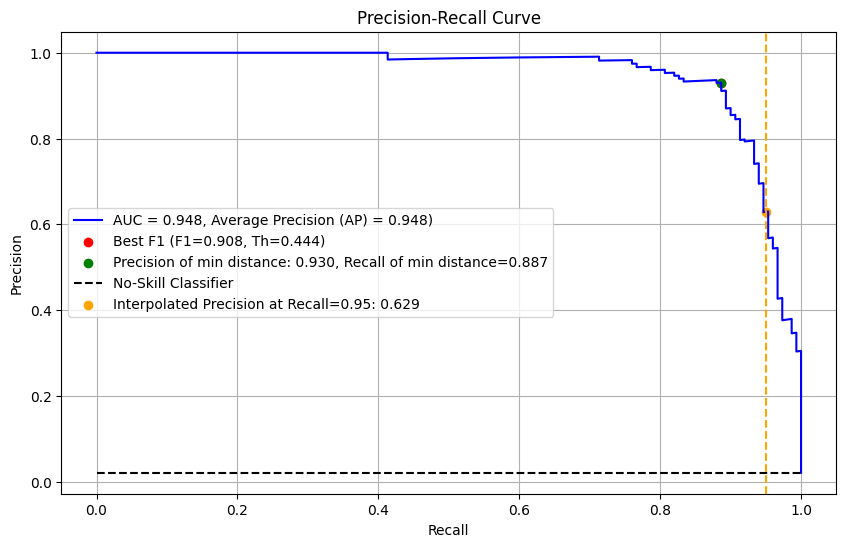

In [ ]:
preds = get_preds(v_filepaths, loaded_model)
th = get_pr_curve(v_labels, preds, False, 'one_shot_GRU_light_augment_40E')
get_metrics_custom(v_labels, preds, v_filepaths, th, False, False, 0, False, 0, 'one_shot_GRU_light_augment_40E')

In [52]:
# Load your trained model
loaded_model = tf.keras.models.load_model('one_shot_GRU_light_augment_40E.keras')

# Wrap in a tf.function and trace it
@tf.function(input_signature=[tf.TensorSpec(shape=[1, 249, 64, 1], dtype=tf.float32)])
def wrapped_model(input_tensor):
    return loaded_model(input_tensor)

# Convert using the concrete function
concrete_func = wrapped_model.get_concrete_function()
converter = tf.lite.TFLiteConverter.from_concrete_functions(
    [concrete_func], trackable_obj=loaded_model)

converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS]

# Try leaving out SELECT_TF_OPS here
tflite_model = converter.convert()

with open('one-shot-gru_40E.tflite', 'wb') as f:
    f.write(tflite_model)